In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.image as img
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, Flatten, Conv2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import tensorflow as tf

In [2]:
# Assigning paths to variables
INPUT_PATH = os.path.join('e:/datasets')
DATASET_DIR = os.path.join(INPUT_PATH, 'landmark-recognition-2020')
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, 'train')
TRAIN_LABELMAP_PATH = os.path.join(DATASET_DIR, 'train.csv')

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'e:/datasets/working/training'
validation_dir = 'e:/datasets/working/validation'
test_dir = 'e:/datasets/working/testing'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size = 8,
    class_mode='categorical',
    seed=42)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size = 8,
    class_mode='categorical',
    seed=42)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size = 1,
    class_mode='categorical',
    seed=42)

Found 48000 images belonging to 400 classes.
Found 16000 images belonging to 400 classes.
Found 16000 images belonging to 400 classes.


In [4]:
model = ResNet50(       weights="imagenet",
                        input_shape=(224, 224, 3)
)

model.trainable = True

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [6]:
with strategy.scope():
    model = ResNet50(classes= 400,
                    weights = None,
                    input_shape=(224, 224, 3))

    model.trainable = True
    model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

## Training

In [7]:
history = model.fit(
    train_generator,
    epochs=8,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/8
6000/6000 [==============================] - 2052s 339ms/step - loss: 6.0736 - accuracy: 0.0103 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 15.1036 - val_accuracy: 0.0284 - val_precision: 0.0132 - val_recall: 0.0019
Epoch 2/8
6000/6000 [==============================] - 1819s 303ms/step - loss: 5.4220 - accuracy: 0.0382 - precision: 0.3750 - recall: 6.2500e-05 - val_loss: 21.5404 - val_accuracy: 0.0501 - val_precision: 0.0165 - val_recall: 0.0029
Epoch 3/8
6000/6000 [==============================] - 1818s 303ms/step - loss: 5.0727 - accuracy: 0.0704 - precision: 0.7969 - recall: 0.0011 - val_loss: 14.6187 - val_accuracy: 0.0926 - val_precision: 0.0719 - val_recall: 0.0093
Epoch 4/8
6000/6000 [==============================] - 1820s 303ms/step - loss: 4.7968 - accuracy: 0.0951 - precision: 0.7727 - recall: 0.0039 - val_loss: 16.2721 - val_accuracy: 0.1100 - val_precision: 0.1096 - val_recall: 0.0168
Epoch 5/8
6000/6000 [==============================] - 1820s 303

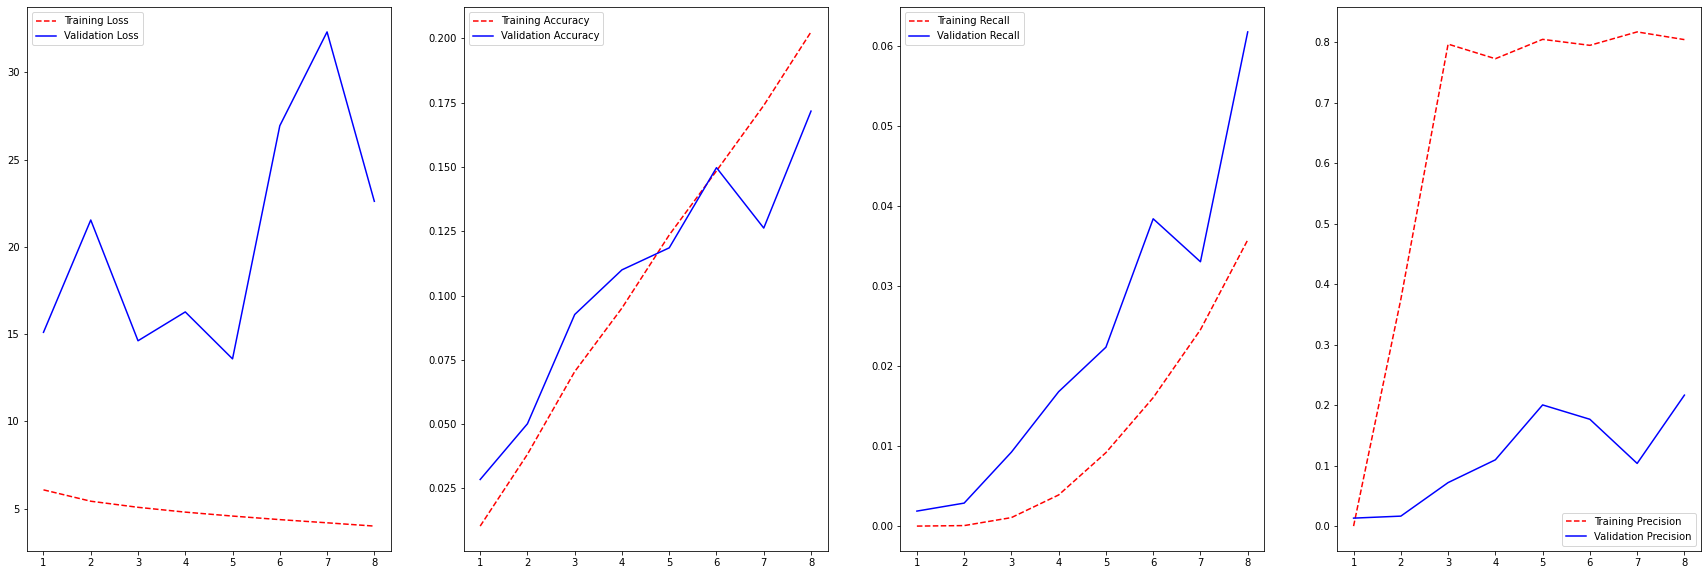

In [8]:


# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [9]:
scores = model.evaluate(test_generator)
print('loss:', scores[0])
print('accuracy:', scores[1])
print('precision:', scores[2])
print('recall:', scores[3])

16000/16000 [==============================] - 406s 25ms/step - loss: 22.8849 - accuracy: 0.1786 - precision: 0.2236 - recall: 0.0642
loss: 22.884864807128906
accuracy: 0.17856250703334808
precision: 0.22364982962608337
recall: 0.06418749690055847


Save model


In [10]:

model.save('resnet_50_30epochs.h5')

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [11]:
np.save('resnet_50.npy',history.history)

In [12]:
hist = np.load('resnet_50.npy',allow_pickle='TRUE').item()

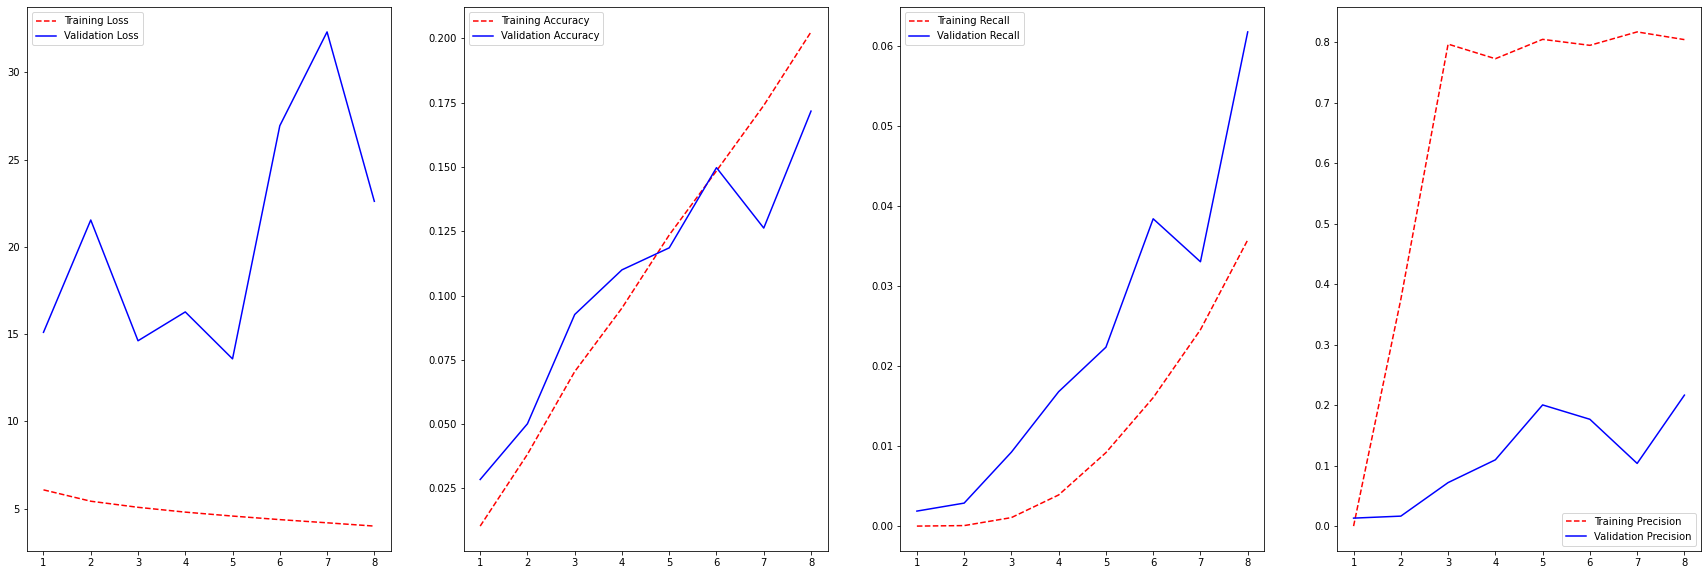

In [13]:
# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = hist['loss']
validation_loss = hist['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = hist['accuracy']
validation_accuracy = hist['val_accuracy']

#let's add accuracy
training_recall = hist['recall']
validation_recall = hist['val_recall']

#let's add accuracy
training_precision = hist['precision']
validation_precision = hist['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

## Resume train

In [14]:
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/2
6000/6000 [==============================] - 1481s 247ms/step - loss: 3.8383 - accuracy: 0.2236 - precision: 0.8164 - recall: 0.0471 - val_loss: 14.6480 - val_accuracy: 0.2301 - val_precision: 0.3367 - val_recall: 0.0891
Epoch 2/2
6000/6000 [==============================] - 1823s 304ms/step - loss: 3.6754 - accuracy: 0.2494 - precision: 0.8146 - recall: 0.0622 - val_loss: 34.9697 - val_accuracy: 0.2218 - val_precision: 0.3014 - val_recall: 0.1027


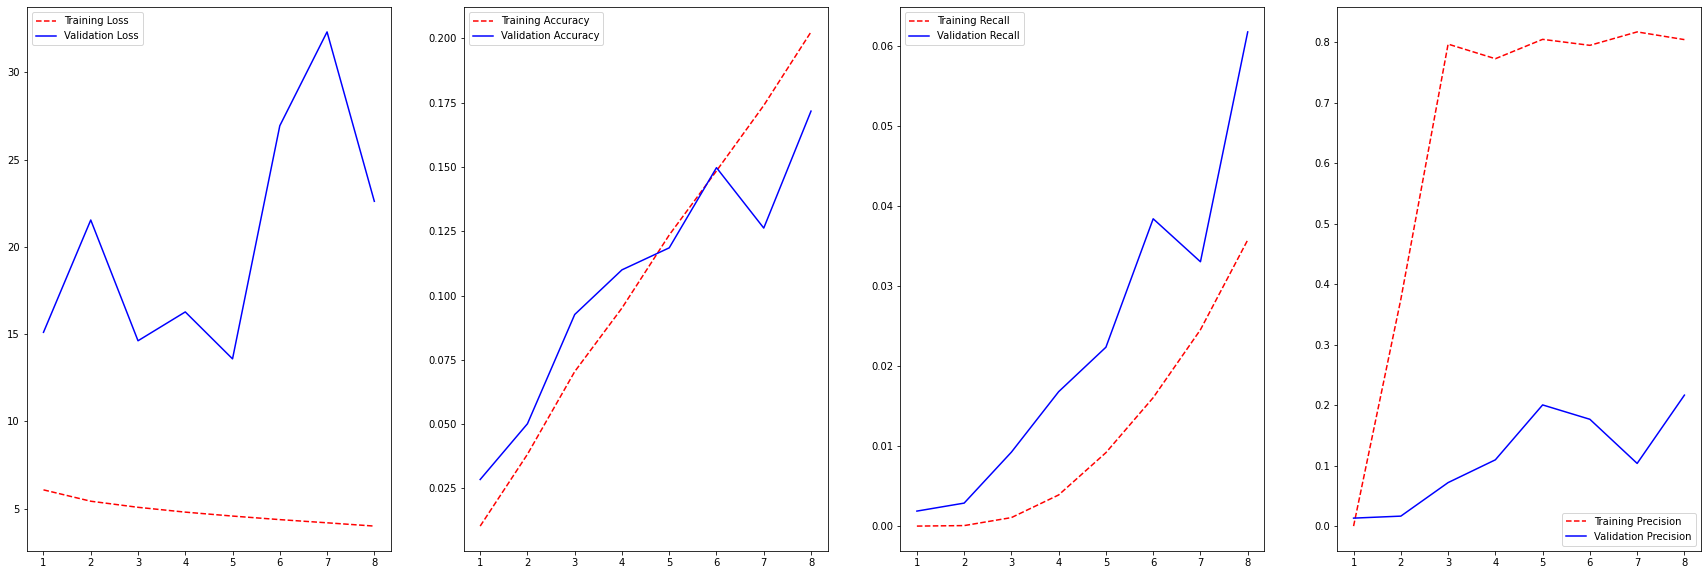

In [ ]:


# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [15]:
np.save('resnet_50_2nd_part.npy',history.history)

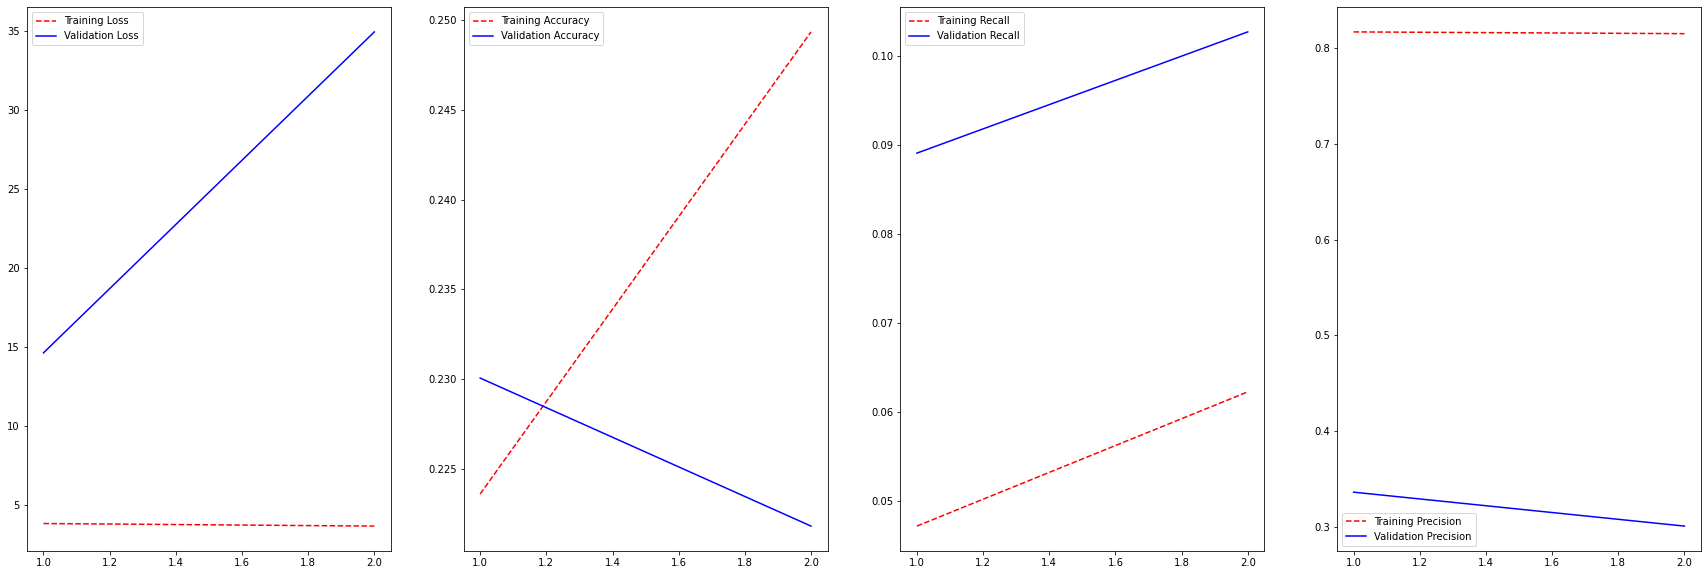

In [16]:


# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [17]:
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/2
6000/6000 [==============================] - 1863s 310ms/step - loss: 3.5300 - accuracy: 0.2699 - precision: 0.8157 - recall: 0.0763 - val_loss: 36.3505 - val_accuracy: 0.2064 - val_precision: 0.2614 - val_recall: 0.1105
Epoch 2/2
6000/6000 [==============================] - 1845s 307ms/step - loss: 3.3777 - accuracy: 0.2962 - precision: 0.8158 - recall: 0.0947 - val_loss: 25.9131 - val_accuracy: 0.2182 - val_precision: 0.2844 - val_recall: 0.1194


In [18]:
np.save('resnet_50_3rd_part.npy',history.history)

In [19]:
model.save('resnet_50_12epochs.h5')

In [20]:
history = model.fit(
    train_generator,
    epochs= 15,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/15
6000/6000 [==============================] - 2156s 359ms/step - loss: 3.2485 - accuracy: 0.3175 - precision: 0.8152 - recall: 0.1135 - val_loss: 33.4537 - val_accuracy: 0.2605 - val_precision: 0.3589 - val_recall: 0.1564
Epoch 2/15
6000/6000 [==============================] - 1839s 306ms/step - loss: 3.1249 - accuracy: 0.3388 - precision: 0.8275 - recall: 0.1326 - val_loss: 25.3444 - val_accuracy: 0.3002 - val_precision: 0.4371 - val_recall: 0.1845
Epoch 3/15
6000/6000 [==============================] - 1825s 304ms/step - loss: 2.9968 - accuracy: 0.3620 - precision: 0.8266 - recall: 0.1512 - val_loss: 11.1762 - val_accuracy: 0.3577 - val_precision: 0.5606 - val_recall: 0.2323
Epoch 4/15
6000/6000 [==============================] - 1825s 304ms/step - loss: 2.8783 - accuracy: 0.3813 - precision: 0.8235 - recall: 0.1723 - val_loss: 17.3316 - val_accuracy: 0.3251 - val_precision: 0.4843 - val_recall: 0.2191
Epoch 5/15
6000/6000 [==============================] - 1825s 304ms/step

In [21]:
np.save('resnet_50_4ер_part.npy',history.history)

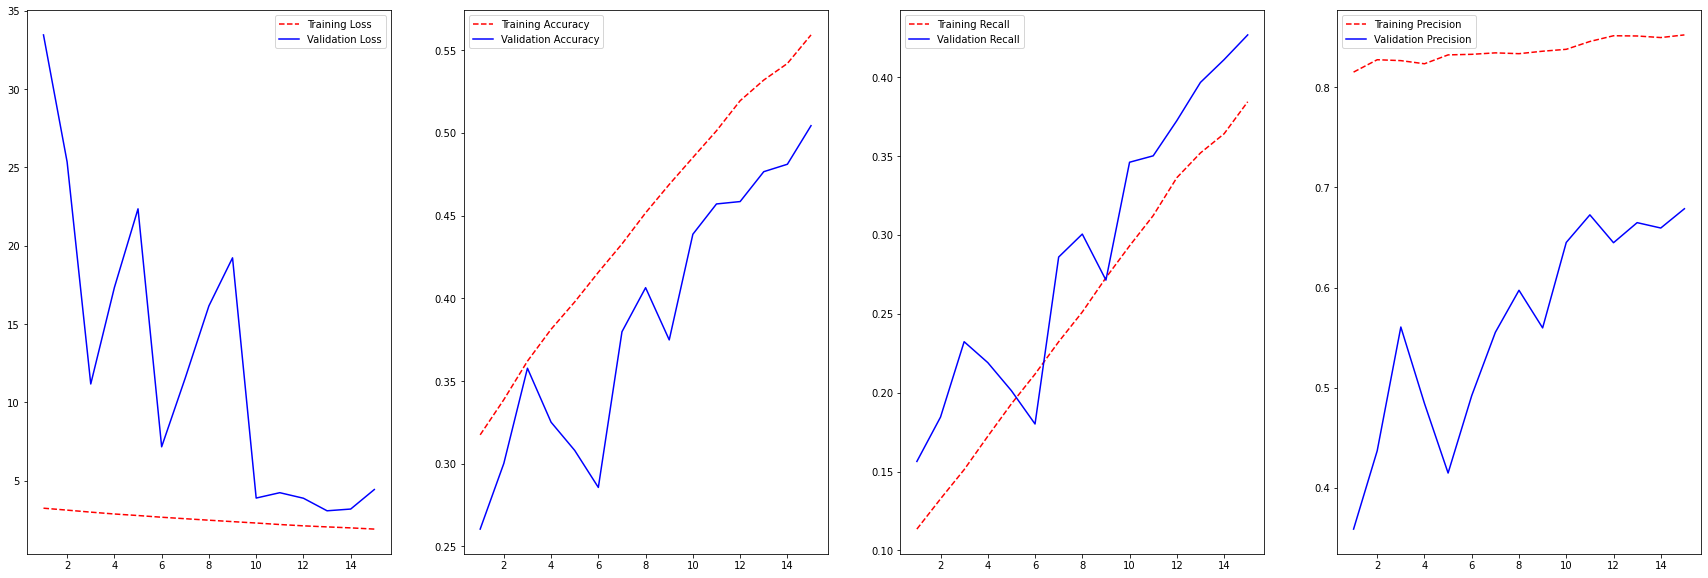

In [22]:


# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [23]:
model.save('resnet_50_27epochs.h5')

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
history = model.fit(
    train_generator,
    epochs= 8,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/8
6000/6000 [==============================] - 2160s 360ms/step - loss: 1.8445 - accuracy: 0.5709 - precision: 0.8578 - recall: 0.4010 - val_loss: 3.0664 - val_accuracy: 0.4771 - val_precision: 0.6407 - val_recall: 0.4106
Epoch 2/8
6000/6000 [==============================] - 1822s 304ms/step - loss: 1.7970 - accuracy: 0.5782 - precision: 0.8550 - recall: 0.4138 - val_loss: 2.8559 - val_accuracy: 0.5236 - val_precision: 0.6884 - val_recall: 0.4530
Epoch 3/8
6000/6000 [==============================] - 1822s 304ms/step - loss: 1.7274 - accuracy: 0.5926 - precision: 0.8576 - recall: 0.4327 - val_loss: 2.2834 - val_accuracy: 0.5384 - val_precision: 0.7255 - val_recall: 0.4556
Epoch 4/8
6000/6000 [==============================] - 1822s 304ms/step - loss: 1.6672 - accuracy: 0.6048 - precision: 0.8610 - recall: 0.4488 - val_loss: 2.2414 - val_accuracy: 0.5452 - val_precision: 0.7235 - val_recall: 0.4717
Epoch 5/8
6000/6000 [==============================] - 1822s 304ms/step - loss: 

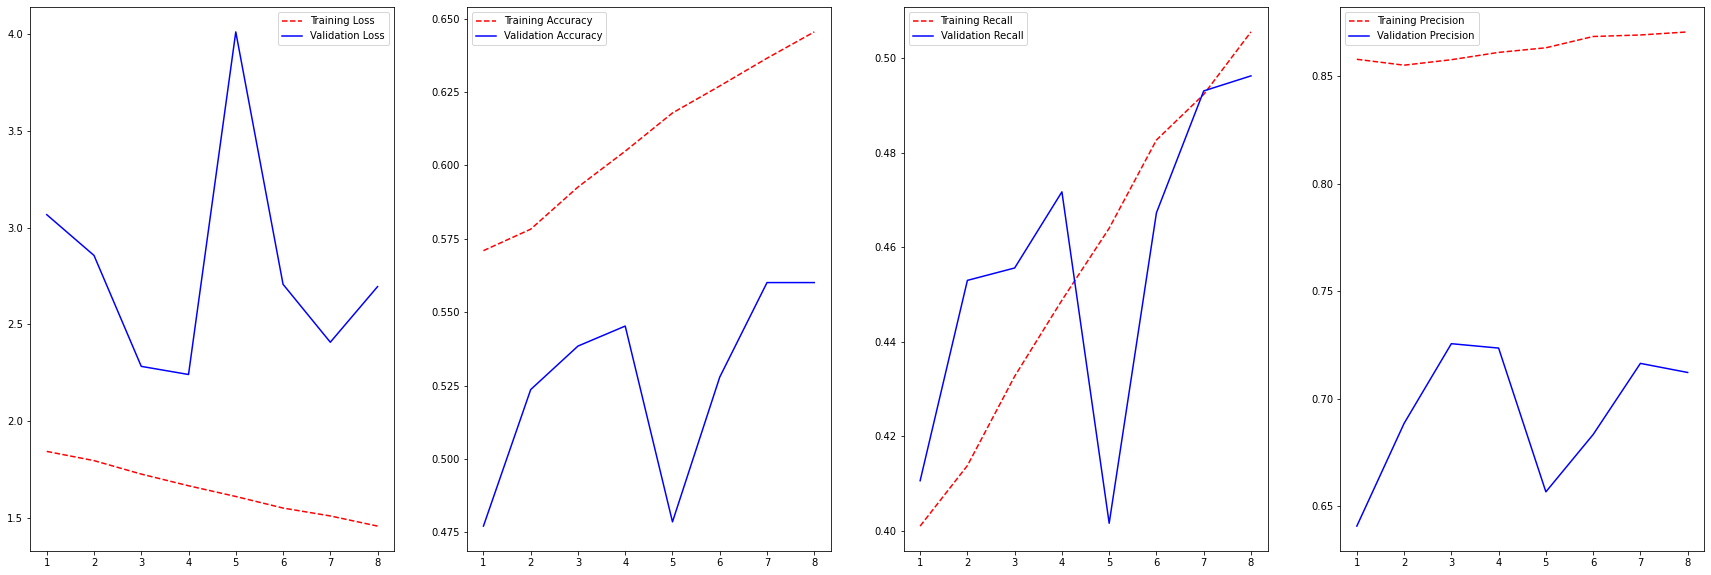

In [25]:
# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [26]:
np.save('resnet_50_5th_part.npy',history.history)
model.save('resnet_50_35epochs.h5')

# load and resume

In [4]:
resnet = tf.keras.models.load_model('e:\\Uni\\NLP\\1st\\models\\resnet_50_35epochs.h5')

In [5]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [6]:
with strategy.scope():
    resnet = tf.keras.models.load_model('e:\\Uni\\NLP\\1st\\models\\resnet_50_35epochs.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [7]:
history = resnet.fit(
    train_generator,
    epochs= 10,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
6000/6000 [==============================] - 2178s 360ms/step - loss: 1.4150 - accuracy: 0.6559 - precision: 0.8732 - recall: 0.5204 - val_loss: 2.1531 - val_accuracy: 0.5842 - val_precision: 0.7427 - val_recall: 0.5153
Epoch 2/10
6000/6000 [==============================] - 1851s 308ms/step - loss: 1.3575 - accuracy: 0.6680 - precision: 0.8741 - recall: 0.5354 - val_loss: 2.3151 - val_accuracy: 0.5483 - val_precision: 0.7220 - val_recall: 0.4762
Epoch 3/10
6000/6000 [==============================] - 1853s 309ms/step - loss: 1.3159 - accuracy: 0.6760 - precision: 0.8765 - recall: 0.5468 - val_loss: 5.5193 - val_accuracy: 0.4759 - val_precision: 0.6160 - val_recall: 0.4186
Epoch 4/10
6000/6000 [==============================] - 1854s 309ms/step - loss: 1.2708 - accuracy: 0.6848 - precision: 0.8779 - recall: 0.5593 - val_loss: 3.2099 - val_accuracy: 0.5663 - val_precision: 0.7116 - val_recall: 0.5033
Epoch 5/10
6000/6000 [==============================] - 1853s 309ms/step - l

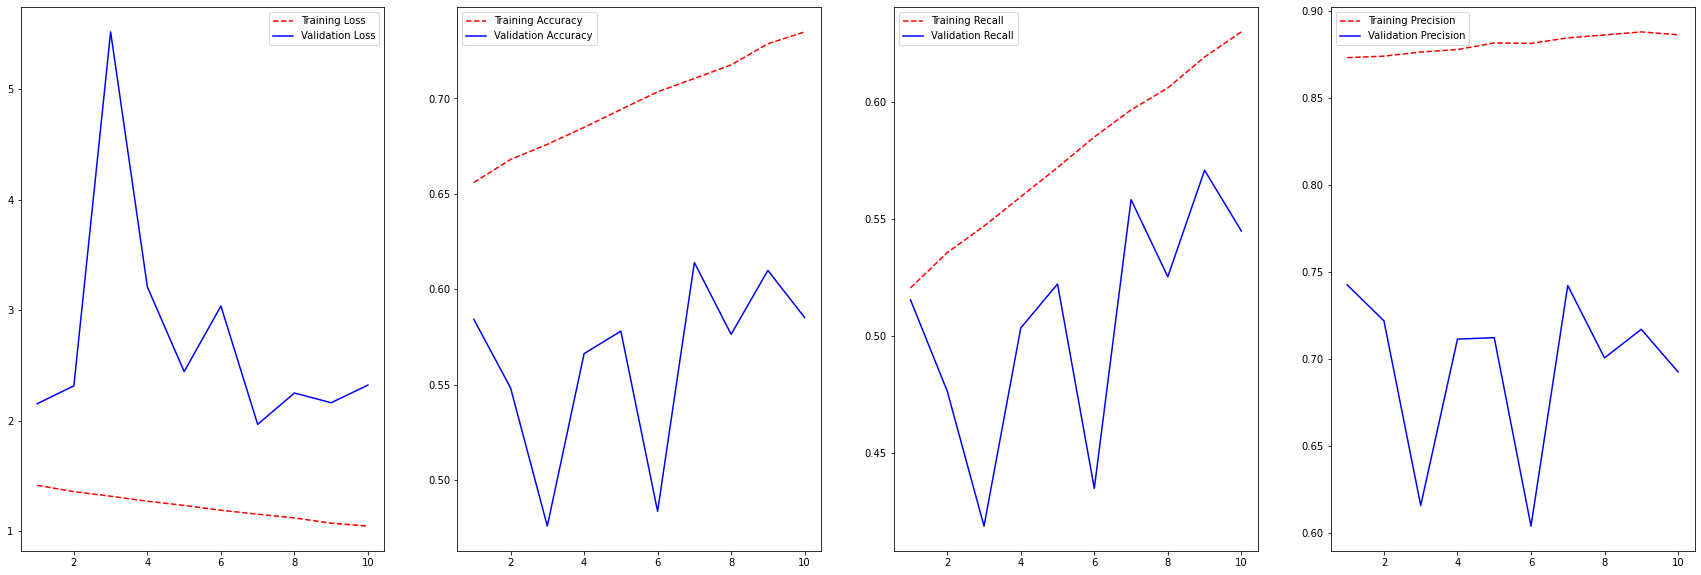

In [8]:
# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [10]:
resnet.save('resnet_50_45epochs.h5')
np.save('resnet_50_6th_part.npy',history.history)

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
